UM MSBA - BGEN632

# Week 10: Advanced Statistical Techniques in Python

In last week's tutorial, we covered the basics of statistics in Python. The purpose of this tutorial to familiarize you with the Python implementation of a few statistical techniques associated with artificial intelligence systems.

1. Data Reduction
    1. Principal components analysis
    2. Factor analysis
    3. Cluster analysis
1. Classification
    1. Regression trees
    2. Classification trees
1. Neural Networks (separate optional tutorial)

---

Let's prepare out notebook before jumping into some math.

## Notebook Setup

### Load Modules

Please remember to install modules before attempting to import them! While we used `sklearn` and `scipy` in Week 9, the `factor_analyzer` and `graphviz` are introduced in this week's tutorial. 

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# for pca
from sklearn import preprocessing
from sklearn.decomposition import PCA as pca

# for factor analysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# for k-means clustering 
import sklearn.metrics as metcs
from scipy.cluster import hierarchy as hier
from sklearn import cluster as cls

# for decision tree 
from sklearn.feature_extraction.image import grid_to_graph
from sklearn import tree

# modules for plotting trees
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

### Set Working Directory

In [27]:
# set working directory
os.chdir("c:\\Users\\winst\\OneDrive\\Desktop\\Python 2\\Week 10\\week10labs\\data")  # change this to your filepath
os.getcwd()  # confirm change

'c:\\Users\\winst\\OneDrive\\Desktop\\Python 2\\Week 10\\week10labs\\data'

### Load Data

In [28]:
# load employee ratings dataset and subset variables of interest in new df
ratings_df = pd.read_table('reduction_data_new.txt')
ratings_df_pca = ratings_df[['peruse01', 'peruse02', 'peruse03', 'peruse04', 'peruse05', 'peruse06', 
                             'pereou01', 'pereou02', 'pereou03', 'pereou04', 'pereou05','pereou06', 
                             'intent01', 'intent02', 'intent03']]

# load k-means example dataset
kmeans_df = pd.read_table('kmeansdata.txt')

# load taxon data
taxon_df = pd.read_table('taxon.txt', sep=' ')
taxon_complete_df = pd.read_csv('taxonomy.txt', sep='\t')

# load plant growth data
pg_df = pd.read_table('pgfull.txt', sep='\t')

# load pollution data and subset variables of interest in new df
pollute_df = pd.read_table('pollute.txt')
pollute_df_trees = pollute_df[['Temp', 'Industry', 'Population', 'Wind', 'Rain', 'Wet.days']]

# load titanic 
titanic_df = pd.read_csv('titanic_data.txt', sep='\t')

In [63]:
# inspect data (remove hash marks at beginning of lines below and then run cell if you would like to see output)
# alternatively, write your own code to inspect data using your preferred approach (e.g., head(), etc.)

#print("\033[1m Employee Ratings DataFrame for PCA and FA demo\n \033[0m")
#ratings_df_pca.info()

#print("\n\033[1m Group DataFrame for Clustering demo\n \033[0m")
#kmeans_df.info()

#print("\n\033[1m Taxon DataFrame for Clustering demo\n \033[0m")
#taxon_df.info()

#print("\n\033[1m Full Taxon DataFrame for Clustering demo\n \033[0m")
#taxon_complete_df.info()

#print("\n\033[1m Plant Growth DataFrame for Clustering demo\n \033[0m")
#pg_df.info()

#print("\n\033[1m Pollution DataFrame for Classification demo\n \033[0m")
#pollute_df_trees.info()

#print("\n\033[1m Titanic DataFrame for Classification demo\n \033[0m")
#titanic_df.info()
titanic_df

,Class,Sex,Age,Survived
0,3rd,Male,Child,No
1,3rd,Male,Child,No
2,3rd,Male,Child,No
3,3rd,Male,Child,No
4,3rd,Male,Child,No
...,...,...,...,...
2196,Crew,Female,Adult,Yes
2197,Crew,Female,Adult,Yes
2198,Crew,Female,Adult,Yes
2199,Crew,Female,Adult,Yes


---

## Data Reduction

A difficulty of any data-driven project is narrowing down the dataset. This is especially true when working with big data. While narrowing the scope of a project can help narrow the data, this often does not sufficiently reduce the data. Additionally, we may not be familiar enough with a dataset to choose the correct variables for a given analysis.

We will go over two methodologies to reduce a dataset: reducing the number of columns and reducing the number of rows. 

The first methodology focuses on reducing the number of columns in a given dataset. *Note that these techniques are not designed to reduce the number of rows in a dataset*. Think of it in terms of reducing the number of variables you want to use. Additionally, these techniques are for structured, quantitative data. These techniques are principal components analysis (PCA) and factor analysis (FA).

The second methodology reduces the number of rows in a dataset. We will focus on a single technique: cluster analysis. Why would we want to reduce the number of rows in a dataset? One reason is that we may not know which subgroup in the data should be the focus of analysis. By using clustering, we can focus on a specific group in a sample.

All of these analyses fall under the umbrella term multivariate statistics. They deal with *multiple* variables. You might assume that because a technique falls under the umbrella of multivariate statistics that there will be target or dependent variables. Data reduction techniques typically do not have a target variable; we refer to them as *unsurpervised learning* techniques. We are not modeling for the sake of prediction or prescription as we did with regression in last week's module. The goal is not to understand how to predict some event or phenomenon. Instead, the goal in data reduction is to *understand what variables or sub-groups should be the focus of analysis* (e.g., in predictive modeling). In this way, data reduction techniques are tools for *exploratory data analysis*. 

### Principal Components Analysis (PCA)

The first column-reducing technique we will focus on is principal components analysis, or PCA. PCA is a technique that creates linear combinations of your columns. In other words, it determines which columns are similar and lumps them together. This process leads to the creation of new columns. If you have 12 columns of data, for example, it may determine that in reality you have only 5 unique columns of data. While this is an oversimplification, it helps illustrate what PCA does.

In most cases, the results of PCA are not used. While PCA creates brand new columns of data, it is very hard to interpret what those columns represent. For example, assume you have a dataset on smartphone sales and two of the variables include annual income and occupation. PCA combines these into a single column based on their similarity. What does this new column represent? Additionally, the data points for each of those columns is now transformed into a linear combination creating new data points for a new column. What are these new data points? Can you interpret them?

The simple answer is "no." The new columns from a PCA can be used effectively within certain types of analyses, but that usage is beyond the scope of this class. Why even talk about it then? While we will not use the newly created columns from PCA, the results from PCA can inform our decision making whenselecting columns of data (i.e., which columns are considered redundant). This process provides a methodology in finding the number of redundant columns of data and removing them. This process is fairly easy to perform once you have learned how to perform it. 

We will perform PCA in conjunction with factor analysis (FA). When performing a PCA followed by a FA you should split your data into two separate halves. You should never use the same sample of data for both. This is similar to creating subsamples for training, testing, and validation. Each one should have different variance from the other. 

When a PCA is performed on data, the result is the creation of components, equal in number to the number of variables you used as input. If you have 6 variables, you will end up with 6 components. Simply put, these components represent a conceptual variable that explains some of the variance in the data.

What does this mean? If your 6 variables are different colored liquids in different cups, what would happen when you pour them into a single pitcher? You end up with a single color, one comprised of all the other colors. What determines the color of the liquid in the pitcher? First, the color of each individual liquid. If you have 3 yellow and 3 blue, you will end up with a fairly even green. What if you have 1 yellow and 5 blue? Not really a green. Second, the intensity of the color. If you have 1 intense yellow and 5 extremely pale blues, you can end up with a very green liquid.

This is how PCA operates. Some variables are more "intense in color" while other variables are more influential because they act as a group and have greater influence than other variables. The components that PCA generates represent the extent to which the "colors" influence the final product.

Two methods are utilized to illustrate the components:

1. Scree Plot
2. Eigenvalues

#### Scree Plot

A scree plot simply generates a chart of the component values. Scree plots are more subjective than assessing eigenvalues. The purpose of using the scree plot is to determine how many components, or columns of data, you are truly dealing with. The way to read a scree plot is determining where the plot levels off and becomes flat; anything prior to that leveling off is a component that remains. 

Run the code cells below to see an example scree plot.

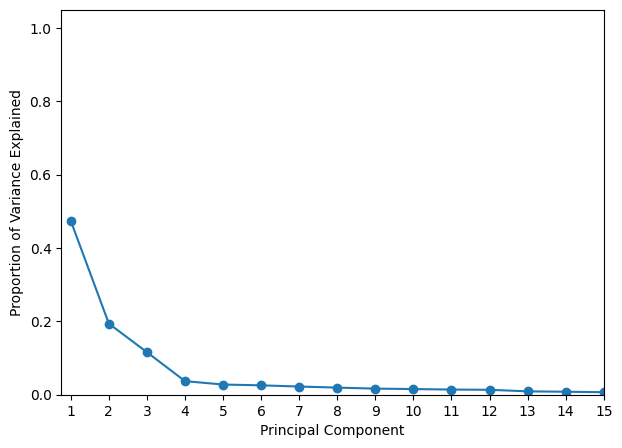

In [30]:
# run the PCA - we specify 15 components because we have 15 variables in the DataFrame
pca_result = pca(n_components=15).fit(ratings_df_pca)

# generate scree plot - focus on the output
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], pca_result.explained_variance_ratio_, '-o')
plt.ylabel('Proportion of Variance Explained') 
plt.xlabel('Principal Component') 
plt.xlim(0.75,4.25) 
plt.ylim(0,1.05) 
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

plt.show()

Scree plots typically have a right-tailed pattern to them. Why? This is because the components are listed (starting on the left) from those that contribute the most influence to those (on the right) that contribute the least amount. Typically, the scree plot exhibits a steep plunge followed by a "leveling off" of the components. The components in the flat plane are not considered very influential while those that are part of the steep plunge are the most influential. In other words, if these components each represent a colored liquid, the first three cups contribute the most to the final, overall color in the pitcher, while the other cups hardly contribute much.

In the scree plot above, you can see that the first 3 components are not flat. Starting with `Component 4` you can see the plot is level and flat. This suggests that out of 15 variables, only 3 should be used for the analysis. This means that some combination of all 15 variables should yield just 3.

#### Eigenvalues

The eigenvalues are more numerical in nature. The eigenvalues are the square of the standard deviation, or the variance. As stated earlier, the purpose of this tutorial is not to go into PCA too deeply, so do not worry too much about why this value is used. What is important is how it is interpreted. A component with an eigenvalue greater than or equal to 1.0 is considered influential.

In [31]:
# obtain eigenvalues - focus on the output
pca_result.explained_variance_

# components from the PCA
# pca_result.components_.T * np.sqrt(pca_result.explained_variance_)

array([9.24664807, 3.782521  , 2.2623671 , 0.72252661, 0.54177949,
       0.49927148, 0.43482191, 0.3789874 , 0.32486612, 0.30119841,
       0.27545114, 0.26150443, 0.1796185 , 0.15909693, 0.133975  ])

Each component has an associated value. You will notice that only three components are larger than 1.0. The way this PCA is assessed is any value greater than 1.0 is retained, while anything less than 1.0 is thrown out. The first three components all have values greater than 1.0. Starting with `Component 4`, however, the values are all smaller than 1.0. What this assessment tells us, is that in reality we are only dealing with 3 variables. The results of the scree plot and eigenvalues are consistent with each other.

We used a relevant metric, percentage of variance explained by the principal component, in the code for the scree plot. We can get and inspect these numbers like so:

In [32]:
# obtain percentage of variance explained by the principal component
pca_result.explained_variance_ratio_

array([0.47407443, 0.19392935, 0.11599126, 0.03704384, 0.02777696,
       0.02559758, 0.02229326, 0.01943063, 0.01665584, 0.0154424 ,
       0.01412234, 0.0134073 , 0.00920902, 0.00815688, 0.00686888])

Note the first value which corresponds to principal component 1: 0.47407443. This indicates that `Component 1` is able to explain 47.41% variance in the data. The value was calculated by dividing the eigenvalue of the first principal component by the sum of all eigenvalues and multiplying by 100:

In [33]:
(9.24664807 / (9.24664807 + 3.782521 + 2.2623671 + 0.72252661 + 0.54177949 + 
               0.49927148 + 0.43482191 + 0.3789874 + 0.32486612 + 0.30119841 + 
               0.27545114 + 0.26150443 + 0.1796185 + 0.15909693 + 0.133975)) * 100

47.40744309465389

We could repeat this calculation with the eigenvalue of each component to produce the values obtained in the `explained_variance_ratio_` output. 

When conducting this analysis, the results from the scree plot and the eigenvalues are compared; you should notice similar results between the two, though you may find that they differ by one component. Once you determine the number of components to use, this informs you how many variables you might want to consider for your data model. At this point, however, you still are unsure which specific variables to use and the PCA cannot yield any more information. We can perform a factor analysis to determine which variables will be removed (or possibly combined with others).

#### Scaling Data 

As a quick aside, sometimes data need to be scaled prior to running a PCA. This will depend on the data. If the variables in a dataset are measured on different scales (e.g., one variable can take any value between 0 and 1 and another variable can take any value between 0 and 100), model performance will suffer. This is because variables on a larger scale will have a stronger effect than variables on a smaller scale. To improve model performance, we can apply a method for scaling data: standardization, normalization, and min-max scaling. These methods transform values so that they are within a specific range (e.g., 0 to 1).  We skipped this step in our code above because the data has the same scaling: all variables in `ratings_df_pca` are measured on the same scale. In this case, the variables are measured on a 7-point scale. However, for the sake of demonstration, here is a code example for scaling with the `ratings_df_pca` DataFrame:

```Python
# import modules
from sklearn.decomposition import PCA as pca
from sklearn import preprocessing

# load and subset data
ratings_df = pd.read_table('reduction_data_new.txt')

ratings_df_pca = ratings_df[['peruse01', 'peruse02', 'peruse03', 'peruse04', 'peruse05', 'peruse06', 
                             'pereou01', 'pereou02', 'pereou03', 'pereou04', 'pereou05','pereou06', 
                             'intent01', 'intent02', 'intent03']]

# scale data using standardization
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(ratings_df_pca)

# run PCA with scaled data
pca_result = pca(n_components=15).fit(scaled_data)
```

### Factor Analysis (FA)

Just like PCA, a factor analysis can help reduce the variables within a given dataset. Factor analysis works by grouping variables or columns of data by how similar they behave. That is, how well do they mimic each other? For example, assume you have three columns of data for the Griz football team: `US shoe size`, `EU shoe size`, and `hair color`. The factor analysis will determine that `US shoe size` and `EU shoe size` behave similarly. It will suggest to you that the measures of shoe size are really the same type of data. You have two potential choices to make: somehow merge the two columns of data or drop one and keep the other. Either way, you will have just two columns.

A factor analysis can be performed using different types of *rotations*. Some rotations assume the data has no relationship and forces them to be *orthogonal* (i.e., not correlated), like a promax rotation. Others assume a relationship such as *varimax* (i.e., correlated). While this is an important concept to know, it is something that is beyond the scope of this class and no further detail will be given. This is mentioned here so that you are aware of its existence. For the sake of this module, only the varimax rotation will be used. In statistics, being conservative in your approach is always better, and assuming that everything is correlated is better than assuming that everything is not correlated.

For this section of the tutorial we will primarily use functions `factor_analyzer` module. 

#### Data Screening

To begin, we will first check the correlation matrix for our variables. Then we will assess the dataset with two tests: Bartlett’s test of sphericity and Kaiser-Meyer-Olkin (KMO) test.

Factor analysis is based on the correlation matrix of the variables of interest. We check the correlation matrix to examine how well the variables relate to one another. We would like to see a variety of correlation coefficient values. Generally, we are concerned about:

* Variables that have no relationship with any other variables (i.e., they do not correlate): $r\lt .30$
* Variables that correlate too highly with other variables: $r\gt .90$
  * We want to avoid extreme multicollinearity or singularity.
  * Extreme *multicollinearity*: variables that are very highly correlated.
  * *Singularity*: variables that are perfectly correlated.

In [34]:
# correlation matrix
ratings_df_pca.corr()

,peruse01,peruse02,peruse03,peruse04,peruse05,peruse06,pereou01,pereou02,pereou03,pereou04,pereou05,pereou06,intent01,intent02,intent03
peruse01,1.000000,0.668359,0.665082,0.621185,0.533357,0.436744,0.132636,0.272083,0.272011,0.322778,0.276411,0.283633,0.243557,0.272509,0.279970
peruse02,0.668359,1.000000,0.757432,0.633420,0.642133,0.549321,0.168717,0.295882,0.289186,0.386221,0.368646,0.277961,0.323890,0.306158,0.398553
peruse03,0.665082,0.757432,1.000000,0.723035,0.680972,0.650180,0.088917,0.320202,0.362880,0.414602,0.357658,0.377137,0.236883,0.310200,0.317993
peruse04,0.621185,0.633420,0.723035,1.000000,0.643392,0.552729,0.133526,0.380608,0.360799,0.350468,0.334318,0.289790,0.160374,0.242164,0.252127
peruse05,0.533357,0.642133,0.680972,0.643392,1.000000,0.651714,0.108821,0.276573,0.287366,0.365810,0.369841,0.333988,0.340873,0.357753,0.392586
peruse06,0.436744,0.549321,0.650180,0.552729,0.651714,1.000000,0.087427,0.239961,0.338286,0.308146,0.333848,0.343034,0.265115,0.350093,0.332928
pereou01,0.132636,0.168717,0.088917,0.133526,0.108821,0.087427,1.000000,0.638550,0.561901,0.487217,0.473139,0.542760,0.140562,0.090014,0.177707
pereou02,0.272083,0.295882,0.320202,0.380608,0.276573,0.239961,0.638550,1.000000,0.725514,0.591354,0.540236,0.610500,0.178283,0.206916,0.235913
pereou03,0.272011,0.289186,0.362880,0.360799,0.287366,0.338286,0.561901,0.725514,1.000000,0.599392,0.560089,0.740153,0.245892,0.283841,0.293159
pereou04,0.322778,0.386221,0.414602,0.350468,0.365810,0.308146,0.487217,0.591354,0.599392,1.000000,0.636981,0.584512,0.308517,0.332332,0.334285


Our correlation matrix has a blend of (not too) low and (not too) high values. Unsurprisingly, variables (items) from the same scale (e.g., intent items) have higher correlations with each other than variables from different scales (e.g., intent and peruse items). This makes sense because the items from the same scale are measuring the same construct.

Next, we will employ Bartlett’s test of sphericity. This tests the null hypothesis that the correlation matrix is an [identity matrix](https://mathworld.wolfram.com/IdentityMatrix.html). 

* *Identity matrix*: a matrix in which all of the diagonal elements are 1 and all off diagonal elements are 0. 

In [35]:
# Bartlett’s test of sphericity -
chi_square_value, p_value = calculate_bartlett_sphericity(ratings_df_pca)
chi_square_value, p_value

(np.float64(1933.2238370791902), np.float64(0.0))

Recall that *p* < .05 is our threshold for significant. As you can see, the *p*-value for our test is 0.0; it is is statistically significant and we can reject the null hypothesis. Note that if it were not statistically significant, we cannot reject the null hypothesis and should not employ a factor analysis. 

Okay, now on to the Kaiser-Meyer-Olkin (KMO) test. The KMO test evaluates the distribution of values, specifically how much shared variance there is between pairs of variables.

In [36]:
# KMO test
kmo_all, kmo_model = calculate_kmo(ratings_df_pca)
kmo_model

np.float64(0.8801187418001309)

KMO values range between 0.0 and 1.0, where a value less than 0.6 is considered inadequate. With a KMO of 0.88, we can proceed with the factor analysis.

#### Factor Extraction

Now we are ready to carry out the factor analysis. In the next code cell, we first choose the number of factors and specify the type of rotation that we will use in the analysis. Then, we fit the factor analysis model. Lastly, we get and inspect the factor loadings matrix. Note that you may see a deprecation warning when you run the code; don't worry about this for now.

In [37]:
# number of factors selected based on PCA results, choosing varimax rotation
fa = FactorAnalyzer(n_factors = 3, rotation='varimax')

# fit FA model
fa.fit(ratings_df_pca)

# get factor loadings
factor_df = pd.DataFrame(fa.loadings_, index=ratings_df_pca.columns, columns=['Factor 1', 'Factor 2', 'Factor 3'])
factor_df

c:\Users\winst\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Factor 1,Factor 2,Factor 3
peruse01,0.700822,0.153299,0.113767
peruse02,0.785512,0.168477,0.184303
peruse03,0.882824,0.188233,0.100017
peruse04,0.781983,0.210319,0.037744
peruse05,0.749676,0.163854,0.218089
peruse06,0.662673,0.172585,0.181124
pereou01,-0.019838,0.729647,0.038422
pereou02,0.192383,0.798773,0.053659
pereou03,0.208235,0.811693,0.122742
pereou04,0.283795,0.675517,0.190914


To evaluate if/how variables have loaded on to factors, we apply a threshold. There is some disagreement about how the factor loading cutoff should be determined. You can read a bit about that [here](https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/thresholds). Again, it is best to be conservative so we will apply a factor loading threshold of 0.6. Based on that, we can observe the following:

* Factor 1 made up of all `peruse` items (perceived usefulness of system).
* Factor 2 made up of the `pereou` items (perceived ease of use of system).
* Factor 3 made up of all `intent` items (intent to use system).

In this case, all items load cleanly on to one of three factors and they load consistently (e.g., all intent items load on to the same factor). If we had observed, for example, that only `intent01` and `intent02` loaded onto the third factor and that `intent03` did not load cleanly on to any factor, then it might be a candidate for removal. 

We could also evaluate our factor analysis based on the explained variance with the following code:

```Python
exp_var_df = pd.DataFrame(fa.get_factor_variance(), index=['Sums of Squared Loadings', 'Proportion of Variance', 'Cumulative Variance'], columns=['Factor 1', 'Factor 2', 'Factor 3'])
exp_var_df  # the cumulative variance is nearly 70% which is acceptable
```

Lastly, we may be interested in deciding if the variables should be averaged within a factor (composite measure) or if it is preferable to select a representative variable for each factor (single-item measure). A composite measure is generally more reliable and has greater validity (in statistical terms). A single-item measure is generally easier to interpret. Some folks recommend selecting representative columns if item factor loadings are not strong ($\gt 0.80$). I recommend that you also consider the complexity of the construct that is being measured and how the items relate to your goal(s) with the overall analysis.

### Cluster Analysis

Clustering is an unsupervised data mining method in which items are grouped into classes of similar data points. Clustering algorithms segment records minimizing within-cluster variance. The algorithms maximize between-cluster variance. Keep in mind, clustering is an *exploratory* analysis technique. It is not a predictive model, but can help you build your model by understanding your data's attributes, characteristics, and nuances. As a comparison, it is similar to database segmentation where the tuples of similar records are listed together.

The purpose of PCA and FA is to reduce the number of columns in a dataset. Cluster analysis allows you to determine grouping within your data. Cluster analysis does this by determining which variables are best for apportioning group membership. Like PCA and FA, cluster analysis is an unsupervised technique; there is no target variable. Many different types of clustering algorithms exist, such as k-means, agglomerative analysis, and divisive clustering.

Cluster analysis attempts to maximize the between-cluster variance and minimizing within-cluster variance. k-means, k-medians, k-modes all are centroid-based algorithms. That is, each cluster is created based on a central point in space in which its data points surround. Hierarchical clustering, which includes agglomerative and divisive, are based on distance of objects to one another, not a centroid.

<div><center>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*nm43wXkfUKrEjF9DLJcapA.png" width=500>
</center></div>

The purpose of the algorithm is to ensure that these groups remain separate by maximizing the between-cluster variance (green arrow) while at the same time minimizing the within-cluster variation (blue arrows).

#### k-means Clustering

k-means is a centroid-based clustering technique. A few different types are available:

* k-means: the most basic version, it is centroid-based on mean averaging effects.
* k-medians: relies on the median and is not sensitive to outliers, unlike mean;
* k-medoids: centroid is not an unrealistic option; uses an actual cluster member (i.e. data point) as centroid;
* Fuzzy Clustering: membership is not based on hard boundaries; a data point can belong to more than 1 cluster;

What does the `k` stand for? This defines the *number of clusters* used in the algorithm. Typically, no a priori reason exists for selecting a value of `k`. When using k-means clustering, you should try multiple values of `k`. Once you have identified the number of clusters, or `k`, then each data point in the dataset is assigned to a cluster. The convergence criteria is based on the squared error.

The following is a simple example to illustrate how the centroid is determined. Consider a dataset with four data points in a three-dimensional (x, y, z) space:
1. (1, 1, 1)
2. (1, 2, 1)
3. (1, 3, 1)
4. (2, 1, 1) 

Averaging x, y, and z together for each point yields the centroid:
* Average the `x` values: $(1 + 1 + 1 + 2)\div{4} = 1.25$
* Average the `y` values: $(1 + 2 + 3 + 1)\div{4} = 1.75$
* Average the `z` values: $(1 + 1 + 1 + 1)\div{4} = 1.00$

This results in the centroid o$(1.25, 1.75, 1.00)$. Note that this data point is not one of the actual values in the dataset. One of weaknesses of the k-means family is that *centroids tend to not be real values in the dataset*.

To help you more fully understand how k-means operates, let's consider a more complex example. Here are the typical steps a k-means algorithm follows:

1. Analyst specifies `k` = number of clusters to partition data
2: Initial cluster centers are randomly assigned to data, creating `k` cluster centers
3: For each row in the data, find the nearest cluster center; each cluster center "owns" a subset of records resulting in *k* clusters, `C1`, `C2`, ..., `Ck` 
4: For each of `k` clusters, find cluster centroid, then update cluster center location to centroid
5: Repeat Steps 3 - 5 until convergence or termination

The k-means algorithm terminates when the centroids, or center of clusters, no longer change.

For this example, assume we have the following data:

| Name | Value |
|:---:|:---:|
| a | (1, 3) |
| b | (3, 3) |
| c | (4, 3) |
| d | (5, 3) |
| e | (1, 2) |
| f | (4, 2) |
| g | (1, 1) |
| h | (1, 2) |

* *Step 1*: `k = 2` specifies the number of clusters to partition
* *Step 2*: Randomly assign `k = 2` cluster centers
  * Assume the program randomly selects `(1, 1)` and `(2, 1)` for cluster 1 (`C1`) and cluster 2 (`C2`), respectively
* *Step 3*: For each record, find the Euclidean distance from points `C1` and `C2`.

| Point | a | b | c | d | e | f | g | h |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Distance from C1 | 2.00 | 2.83 | 3.61 | 4.47 | 1.00 | 3.16 | 0.00 | 1.00 |
| Distance from C2 | 2.24 | 2.24 | 2.83 | 3.61 | 1.41 | 2.24 | 1.00 | 0.00 |
| Membership | C1 | C2 | C2 | C2 | C1 | C2 | C1 | C2 |

The results of this initial pass through the data results in the following:

* `C1: a, e, g`
* `C2: b, c, d, f, h`

Next, the Sum of Square Error (SSE) is calculated from Euclidean distances:
* $SSE = 2.00+2.24+2.83+3.61+1.00+2.24+0+0$
* $SSE = 36.0$

Recall that *between-cluster variation (BCV) is maximized* and *within-cluster variation (WCV) is minimized*. The smallest *SSE* through all iterations is desired; though, you may not find the optimal minimum. It depends on where the cluster centroids are seeded. Since it is typically randomly selected, each time you run the algorithm may yield different results.

Moving on to the next step:
* *Step 4*: For `k` clusters, find cluster centroid, update location
  * $C1 = [((1 + 1 + 1)\div{3}), ((3 + 2 + 1)\div{3})] = (1, 2)$
  * $C2 = [((3 + 4 + 5 + 4 + 2)\div{5}), ((3 + 3 + 3 + 2 + 1)\div{5})] = (3.6, 2.4)$

At this point, the process iterates through steps 3 through 4 until convergence occurs. Convergence may occur when the cluster centroids are essentially static and do not change, the rows of data do not change cluster membership, or other stopping criteria is fulfilled such as time or number of iterations.

k-means is not guaranteed to find global minimum *SSE*. Instead, the local minimum may be found (due to seeding). Invoking an algorithm using a variety of initial cluster centers improves probability of achieving a global minimum. One approach places the first cluster at random point, with the remaining clusters placed far from previous centers.

A few caveats. k-means is unable to handle categorical data. In addition, basic k-means cannot handle outliers. Recall that extreme values have a strong effect on mean. Consider using k-medians if extreme outliers are present. If the dataset contains categorical data, then we can use k-modes. This family of clustering techniques is not time efficient and does not scale well. Additionally, business domain knowledge is required to choose $k$ and interpret the results.

##### Cluster Analysis in Python

We will use `kmeans_df` in this section of the tutorial. This dataset contains four variables, two of which are categorical: `group` and `grouping`. The variable `grouping` has values A, B, C, D, E, and F. These represent natural groupings within the data. When using clustering, we do not typically have variables such as `grouping` or `group` because we are unaware of how the data group together. We are merely using this data to illustrate how clustering works.

k-means is based on the idea that you choose the number of clusters *k* and the algorithm will determine, based on initial seeding, where those clusters are in the data.

In this demonstration, we will  convert our categorical data and then process the data using 4 and 6 clusters, respectively.

In [38]:
# convert to categorical datatype
kmeans_df['group'] = kmeans_df['group'].astype('category')          
kmeans_df['grouping'] = kmeans_df['grouping'].astype('category')

In [39]:
# use 4 clusters
km_4 = cls.KMeans(n_clusters=4).fit(kmeans_df.loc[:, ['x', 'y']])

# assigned clusters
km_4.labels_

array([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0,
       2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0], dtype=int32)

In [40]:
# use 6 clusters
km_6 = cls.KMeans(n_clusters=6).fit(kmeans_df.loc[:, ['x', 'y']])

# assigned clusters
km_6.labels_

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 0,
       0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 5, 5,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 5,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

The classification of the data for both cluster algorithms performs fairly well. The results of the 4-cluster result `km_4.labels_` shows some consistency (pay attention to grouping of values). When the clustering is switched to the 6-cluster group `km_6.labels_`, the results appear to be improved.

We can assess misclassification using a confusion matrix in Python. The next two images show two methods to accomplish this. The first is a text-based matrix that does not have labels (though, that is something you could easily change). The second figure presents a color-based gradient of the exact same data. 

In [41]:
# confusion matrix - numerical representation
cm = metcs.confusion_matrix(kmeans_df.group, km_6.labels_)
cm

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0],
       [17,  0,  0,  0,  0,  8,  0],
       [ 0,  0,  0, 25,  0,  0,  0],
       [ 0,  0,  2,  1, 17,  0,  0],
       [ 0,  0, 25,  0,  0,  5,  0],
       [ 2, 23,  0,  0,  0,  0,  0]])

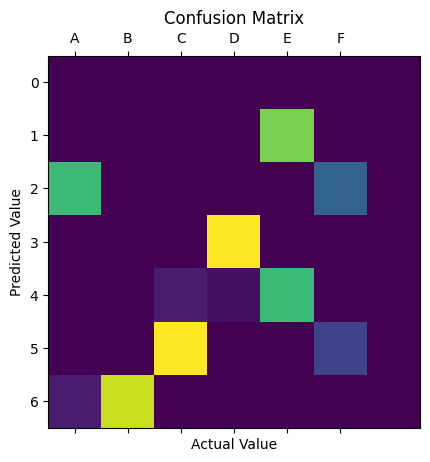

In [42]:
# confusion matrix - graphical representation
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks([0,1,2,3,4,5], ['A','B','C','D','E','F'])

plt.show()

In both the numerical and graphical representations of the confusion matrix, we can see that group `A` is perfectly assigned to cluster `6`. Group `B` was mostly placed in cluster `5` with one member in cluster `2` and two in cluster `4`. Groups `C` and `F` have the worst placement. Despite this, the clustering did a fairly good job with the overlapping data.

##### k-means Clustering Performance

This next example helps illustrate that clustering may not always perform well. We will use `taxon_df` for this demonstration. The dataset contains 120 observed plants from 4 different islands. Specific characteristics, represented as seven variables, for taxonomy were measured for all plants.

A k-means algorithm is run on the data for 4 clusters. Run the code cell below to see the results. The data itself is sorted so that the first 30 observations belong to taxon I, the next 30 to taxon II, the next 30 to taxon III, etc. This cluster analysis was performed with 4 clusters; however, as you will see, the results are not very good.

In [43]:
taxon_km = cls.KMeans(n_clusters=4).fit(taxon_df)

taxon_km.labels_

array([2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 2, 0, 0, 1, 0, 0, 3, 0, 0, 2, 0, 2, 0, 2, 0, 2, 3, 0, 1, 2, 2,
       3, 0, 3, 2, 2, 1, 2, 0, 0, 0, 3, 2, 2, 2, 0, 1, 3, 0, 2, 2, 2, 3,
       1, 2, 3, 2, 3, 2, 3, 3, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       3, 2, 2, 3, 3, 3, 2, 3, 2, 2], dtype=int32)

Look at the first 30 records; the observations are placed across different clusters. All of these observations should be just one single cluster. The next group of 30 exhibit a similar issue. Clustering did not perform very well. If we run the clustering algorithm again with just 3 clusters, instead of 4, the results come out cleaner. This won’t do, because we know this data contains 4 groups. There are other statistical techniques that may produce categorization on this data. 

[Read more about k-means clustering here](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).

We will now shift our discussion to some other clustering approaches.

#### Hierarchical Clustering

This type of clustering is based on the distance of objects to one another (i.e., dendrogram). A dendrogram is a diagram representing a tree.

* Agglomerative: single elements merge into clusters
  * Single Linkage - nearest neighbor
  * Complete Linkage - similarity based on farthest data points
* Divisive: start with dataset and divide into subsets
  * Single Attribute - similarity is based on possessing similar values from those that differ
  * All Attribute - like Single Attribute, except more than one attribute is taken into consideration

##### Agglomerative Analysis

We will now try our hand at a hierarchical clustering technique, agglomerative analysis, for categorization of the taxon data. We will also use the full taxonomy data we imported in notebook setup as `taxon_complete_df`. 

Agglomerative is an additive process. It starts out with each observation and slowly clusters them, based on Euclidean distance, until only one cluster remains. Run the code below to see an example dendrogram with the taxon data.

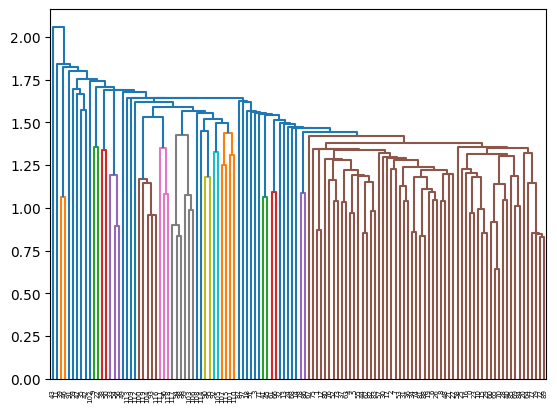

In [44]:
z = hier.linkage(taxon_df, 'single')
dn = hier.dendrogram(z)
plt.show()

Compared to the k-means clustering performed earlier, the results are not really improved. No matter which break we look at, the clusters involve observations from more than one group. Clustering did not appear to perform very well with this data. This is an important lesson to learn about clustering. Clustering may not find a global optimum; in many situations it only finds the local optimum. 

To help further illustrate this, let's generate a decision tree (we will elaborate on these later). Note that we are now using `taxon_complete_df`. Run the code cell below to generate and visualize the decision tree.

In [46]:
# use one-hot encode for categorical variables
onehot_data = pd.get_dummies(taxon_complete_df[['Petals','Internode','Sepal','Bract','Petiole','Leaf','Fruit']], drop_first=True)

# create a decision tree classifier instance
tree_model = tree.DecisionTreeClassifier(criterion='gini')

# fit the model
tree_example = tree_model.fit(onehot_data, taxon_complete_df.Taxon)

We can use the built-in function from the `tree` library to plot the tree.

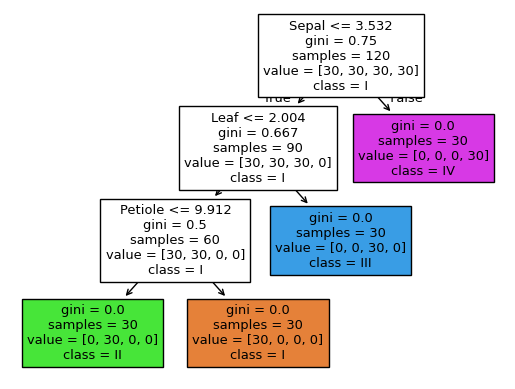

In [47]:
# include the feature names
tree_labels = list(onehot_data.columns.values)

# define the class names
tree_cn = list(taxon_complete_df.Taxon.unique())
tree.plot_tree(tree_example, feature_names=tree_labels, class_names=tree_cn, filled=True)
plt.show()

We can see that the tree was able to partition the data into four separate groups based on `Sepal`, `Leaf`, and `Petiole`. This is much cleaner than clustering. 

In various projects you engage in, it is often beneficial to attempt multiple types of statistical techniques. This process allows you to see where your analyses differ and agree. The temptation, typically, is to use a single process and then accept the results at face value. Don’t just settle for using one type of analysis!

##### Another Agglomerative Analysis Example

Okay, one more hierarchical clustering example. Again, we will apply agglomerative analysis. 

For this section of the tutorial, we will use `pg_df`. This data provides observations on plant growth for 54 plant species on 89 plots of land.

We calculate the Euclidean distance for all of the rows and columns. Note that we will only do this for the first 54 columns; the other 5 (plot, lime, species, hay, pH) are not considered for this. Once calculated, the results can be plotted.

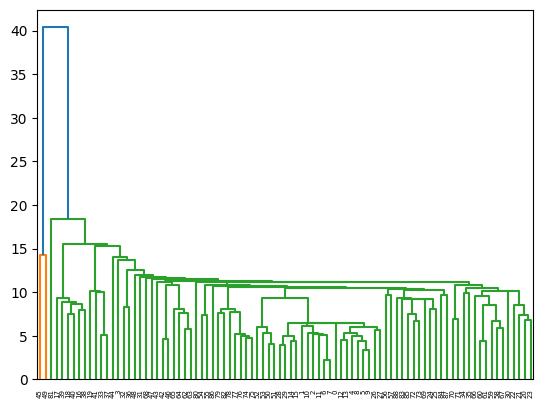

In [48]:
# fit model
agg_example = cls.AgglomerativeClustering(linkage='ward').fit(pg_df.iloc[:,0:54])
agg_example.labels_

# visualize results
z = hier.linkage(pg_df, 'single')
dn = hier.dendrogram(z)
plt.show()

Observe the second break in the clustering (the second blue line from the left). The plants on the left of the break belong to land plots 11 and 14. The land plots 11 and 14 are high-nitrogen plots receiving phosphorus.

We will not go into detail or cover examples on the next two clustering approaches. They are introduced so that you are aware of these clustering approaches. 

#### Gaussian Mixture Models (GMM)

Distribution-based models relying on the probability of a point being related to the centroid. Think of a three-dimensional bell-shaped curve. GMM utilizes variance and means to generate groupings. The `sklearn.mixture` package provides code for GMM implementation. [Check out the documentation for more information](https://scikit-learn.org/stable/modules/mixture.html).

#### Density-based Clustering

Data points are associated into clusters based on density criteria among a set of points; i.e. more dense areas are clustered. Unlike k-means clustering, density-based clustering is not restricted to elliptical shapes. This tends to provide a more organic clustering. A density-based clustering approach, the DBSCAN algorithm, is provided with scikit-learn. [Check out the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

## Classification

These class of statistical techniques are some of the most popular. These are considered *supervised learning* techniques because they have target variables. The output variable is categorical (nominal or ordinal) in nature. The purpose of this family of techniques is to classify data based on a class label (your target variable). 

For example, we could have a dataset containing incoming internet traffic for a fictional business. The data contains many columns of information such as origination URL, origination datetime, content, size (in MB), and threat level. Threat level can be a binary value, `high` or `low` assigned by the firewall. Using classification, the variable `threat level` is the target. Using the other columns of data, the values in one are assigned to either the `low` or `high` value of `threat level`. How can we use this? we can program an automated script to use those values to determine if incoming traffic is a threat to our organization. If the traffic is labeled as `high`, then we block it.

### Insurance Example

To help illustrate how classification operates, let's consider another example. In this example, we are developing a model to help sift new automobile insurance customers into low or high risk status. High-risk customers are more expensive, and should be billed a higher premium. Assume we have the following data:

| Age | Gender | Car Type | Risk |
|:---:|:---:|:---:|:---:|
| 20 | Male | SUV | High |
| 18 | Female | Sport | High |
| 40 | Male | Sport | High |
| 50 | Male | Sedan | Low |
| 33 | Female | Minivan | Low |
| 31 | Female | Sedan | Low |
| 29 | Male | Sedan | High |
| 47 | Female | Truck | Low |

The following classification tree is generated. Note, the most important factor in determining risk is age. Those who are 30-years of age or younger are automatically classified as *high risk*. The next criteria is the type of vehicle. In the image below, a `Sport` type of vehicle is automatically placed in the *high-risk* group. 

<div><center>
<img src="assets/insurance_classification.png" width=500>
</center></div>

This model is valuable to the insurance company. When new customers apply for insurance, the model can automatically assign them into a category and generate an estimate of cost. For example, assume a new set of customers apply for insurance.

| Age | Car Type |
|:---:|:---:|
| 27 | Sport |
| 34 | Minivan |
| 55 | Truck |
| 34 | Sport |

The classification model will then assign the following risk classifications:

| Age | Car Type | Risk |
|:---:|:---:|:---:|
| 27 | Sport | High |
| 34 | Minivan | Low |
| 55 | Truck | Low |
| 34 | Sport | High |

### Types of Classification and Accuracy

Many different types of classification techniques exist. The following are just a few:

* Decision tree techniques
  * CART (Classification and Regression Tree)
  * ID3/4/5 Algorithms and numerous variants
* Statistical analysis 
  * Logistic Regression (presented in last week's tutorial)
  * Bayesian classifiers
* Neural networks
* Support vector machines
* Case-based reasoning/Genetic algorithms

Not all classification models are built exactly the same. Many methods exist to determine the accuracy of the classifier. One such method is a confusion matrix. Simply put, a confusion matrix compares the predicted values of the data against the actual values of the data. In other words, how well did the classifier do its job?



<table>
<thead>
<tr><th></th><th></th><th colspan="2">True Class</th></tr>
<tr><th></th><th></th><th>Positive</th><th>Negative</th></tr>
</thead> 
<tr><th style="border-top-style: hidden;" rowspan="2" scope="rowgroup">Predicted Class</th>
    <th style="border-top-style: hidden;" scope="row">Positive</th>
    <td bgcolor="#90d696"; align="center">True Positive Count (TP)</td>
    <td bgcolor="#ff9494"; align="center">False Positive Count (FP)</td>
</tr>
<tr><th scope="row">Negative</th>
    <td bgcolor="#ff9494"; align="center">False Negative Count (FN)</td>
    <td bgcolor="#90d696"; align="center">True Negative Count (TN) </td></tr>
</table>

### Decision Trees

A decision tree is a structure that can be used to divide up a large collection of records into successively smaller sets of records by applying a sequence of simple decision rules ([Linoff & Berry, 2011](https://dl.acm.org/doi/abs/10.5555/2543983)). Decision trees consist of a set of rules for dividing a large heterogeneous population into smaller and smaller homogeneous groups based on a target variable. The target variable is usually categorical. As you saw in our discussion on clustering, a decision tree can operate similarly to a cluster technique to reduce the number or records in a dataset.

Decision trees are popular for both classification and thus prediction (Supervised/Directed). The attractiveness of this approach is due largely to the fact that decision trees represent rules expressed in both English and SQL. This makes interpretation straight-forward and simple. Also, they can be used for data exploration, becoming a powerful first step in model building. Although decision trees can be used to estimate continuous values, there are better ways. When used for estimation, the term should be *regression trees* instead of *decision trees*.

How do decision trees work their magic? They recursively divide data until each division consists of examples from one class. These steps include
1. Create a root node and assign all of the training data to it
2. Select the best splitting attribute
3. Add a branch to the root node for each value of the split. Split the data into mutually exclusive subsets along the lines of the specific split
4. Repeat steps 2 and 3 for each and every leaf node until the stopping criteria is reached

During the growth phase, the tree is built by recursively partitioning the data until each partition is either **pure** (contains members of the same class) or sufficiently small. The form of the split used to partition the data depends on the type of the attribute used in the split.
* For a continuous attribute A, splits are of the form `value(A) < x` where `x` is a constant value in the domain of `A`.
* For a categorical attribute A, splits are of the form `value(A) ∈ x` where `X` is in the domain of `A`
* For a missing value; preferable to throwing out the record or imputing a value; consider null as its own branch

While growing the tree, the goal at each node is to determine the split point that *best* divides the training records belonging to that leaf. A *full tree* is reached when it is not possible to do any more splits or to a predetermined depth. Note that full trees may not be best at classifying a set of new records. 

Depending on the type of predictor variables you are using for your target will determine which type of splitting occurs. In addition, continuous and categorical variables behave differently. For continuous variables, because numeric inputs are only used to compare their values at the split points, decision trees are not sensitive to outliers or skewed distributions. This can be valuable if your data contains lots of outliers and you are unable to remove them. 

If you are using categorical variables, the simplest approach is to split on each class (level) of the variable if you have more than two. However, this often yields poor results because high branching factors quickly reduce the population of training records available for lower nodes. An approach around this is to group the classes that, taken individually, predict similar outcomes.

We will now go over some examples of regression trees and classification trees in Python. We will use `pollute_df_trees` and `taxon_complete_df` in this next section of the tutorial.

### Regression Trees

The tree function in Python comes from the library `sklearn` library. This is a class object you pass data into. scikit-learn provides a classification tree and a regression tree. The tree function uses the `Gini Index` as default, but you can switch to `entropy`.

The classification tree and regression tree within the `sklearn` provides many options. Some of these options are useful for pruning the tree. Some of the more important ones are listed below:
* `max_depth`: an integer representing the number of *levels* for nodes
* `max_leaf_nodes`: the best nodes are selected when growing the tree until the number is reached; when used, `max_depth` is ignored
* `min_samples_split`: the minimum number of samples each node requires for a split to occur
* `min_samples_leaf`: the minimum number of samples required at a leaf node

Using the pollution data, the following code is run to create the regression tree:

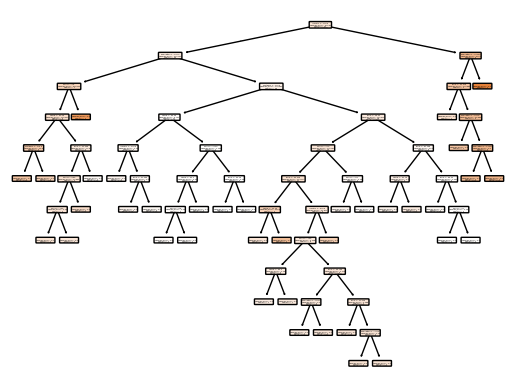

In [49]:
tree_model_2 = tree.DecisionTreeRegressor().fit(pollute_df_trees, pollute_df.Pollution)

col_names = list(pollute_df_trees.columns.values)

tree.plot_tree(tree_model_2, feature_names=col_names, filled=True, rounded=True)

plt.show()

The output is too large to adequately display within this document. However, you can see that the output contains many nodes and leaves; it is not very useful. We could modify the figure size by increasing font size of `plot_tree()` and figure size of `plt.figure()` to make our figure more readable.

```Python
plt.figure(figsize=(10,8))  # set plot size (denoted in inches)
tree.plot_tree(tree_model_2, feature_names=col_names,
                filled=True, rounded=True,
                fontsize=10)  # set font size
plt.show()
```

Or, we can use the `graphviz` module which gives us more options for output format and size. Even without customizing the font and figure size, `graphviz` gives us a more readable figure.

In [50]:
tree_mod_graph = export_graphviz(tree_model_2, filled=True, feature_names=col_names)
graph = graphviz.Source(tree_mod_graph, format="png")  # or "svg" for better resolution
display(graph)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

This is a little easier to read (but still not great given the size of the tree). Take a look at the first split for `Industry`. The split value is at 748. The right side of the split, that with False, reduces the sample size per node past 5. For example, after `Population`, `Rain` has a sample of only 4 while the next split of `Population` has 3.

Next we will try using the criteria `min_samples_split` and `min_samples_leaf` and set both to 5 in order to optimize our model: 

In [51]:
# create model
tree_model_2 = tree.DecisionTreeRegressor(min_samples_split=5, min_samples_leaf=5)
tree_model_2.fit(pollute_df_trees, pollute_df.Pollution)

# visualize tree with graphviz
tree_mod_graph = export_graphviz(tree_model_2, filled=True, feature_names=col_names)
graph = graphviz.Source(tree_mod_graph, format="png") # or "svg" for better resolution
display(graph)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

The results are much improved. The results of the tree are well plotted for a visual representation. The output reveals `Industry` is the first split and represents the most important variable for splitting.

How did the algorithm determine `Industry` as the first split to represent the most important variable for splitting? To help explain the process of the tree operation, the following plot is created. On the *y*-axis is the target, `Pollution`; on the *x*-axis is `Industry`.
<br>
<div><center>
<img src="assets/industry-pollution.png" width=500>
</center></div>  
<br>

Each independent variable is assessed by determining how much deviance in the dependent variable is explained. Deviance can be thought of as the measurement of explanatory power of a tree, like $R^2$ is for regression. In this case, `Industry` explains the most for `Pollution`. The deviance is based on a threshold value for each predictor; it produces two mean values: 1 above the threshold, and one below. The value 748 (the dashed, vertical line in the figure above) is the chosen threshold value of `Industry` based on deviance.

The mean values for the two groups are shown via the two horizontal lines. Both of these mean values are used to calculate the deviance. The algorithm iterates through all *x*-values of `Industry` as the threshold (i.e. the vertical line); a mean below and above the threshold is calculated (i.e. the horizontal lines). For each threshold, the *x*-value with the lowest deviance is chosen. The data set is then split based on this threshold value. The program then runs through the other independent variables for each of the new data subsets. This continues until further deviance is not possible or there are too few data points (fewer than 6 cases is default).

#### Cost Complexity

An important question is, "How do I determine how many nodes to prune from a tree?" Does an objective method exist to help with pruning? We will go over one method that relies on the concept of cost complexity. As cost complexity increases, so too does the number of nodes pruned. Said a different way, as the number of nodes decrease, the more cost complexity increases.

For this, we will create a training and testing subset from the original data. We use the method `cost_complexity_pruning_path()` to extract the alpha values and impurities associated with the minimal cost complexity path. At this time we are not interested in the impurities; only the alpha values. The alpha values are the cost complexity scores. Essentially, we are looking for the alphas (i.e., cost complexity scores) with the smallest value. The nodes with the smallest alphas are pruned first.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(pollute_df_trees, pollute_df.Pollution)
path = tree_model_2.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Now that we have a list of the alphas, we will train a tree using those alpha values:

In [53]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1])
    )


Number of nodes in the last tree is: 3 with ccp_alpha: 173.72190476190474


We output the last value in the list `ccp_alphas` which will return the number of nodes and the alpha value. In a moment, we will confirm this in a plot. The last step is to generate two plots. The first plots the number of nodes against cost complexity. Look at the last data point in the first plot below. This confirms what we showedin the printed statement above. The second plot provides the depth of the tree (i.e., number of levels) against the cost complexity.

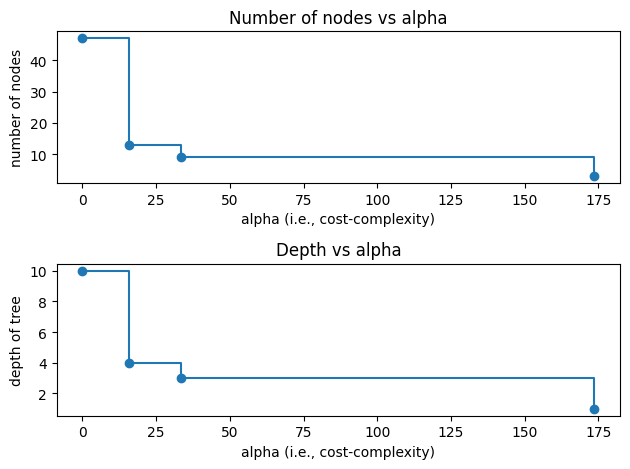

In [54]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha (i.e., cost-complexity)")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha (i.e., cost-complexity)")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

We see in these plots that as alpha increases, the number of nodes and the number of levels of the tree decrease. This is an inverse relationship, which is expected for a tree. We can use this to inform decision making for pruning. Specifically, we can identify where the most drastic change for alpha occurs for both number of nodes and depth. This is where we can effectively reduce the size of the tree.

### Classification Trees

Recall that the `taxon_complete_df` data for the classification tree contains taxon data for various plant flora and fauna with the following variables:

* Taxon
* Petals
* Internode
* Sepal
* Bract
* Petiole
* Leaf
* Fruit

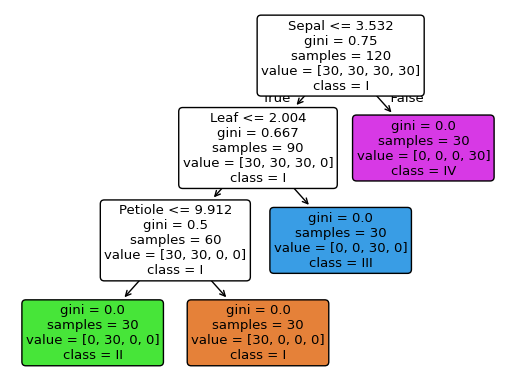

In [55]:
# get labels
col_names = list(taxon_complete_df.columns.values)
cls_names = list(taxon_complete_df.Taxon.unique())

# use one-hot encode for categorical variables
onehot_data = pd.get_dummies(taxon_df[['Petals', 'Internode', 'Sepal', 'Bract', 'Petiole', 'Leaf', 'Fruit']], drop_first=True)

# fit model
tree_model_2 = tree.DecisionTreeClassifier().fit(onehot_data, taxon_complete_df.Taxon)

# visualize tree
tree.plot_tree(tree_model_2, feature_names=col_names[1:8], class_names=cls_names, filled=True, rounded=True)
plt.show()

The resultant tree is plotted above. It may help to have the data in front of you to compare. The first class, `Class IV`, is distinguished by the size of the `Sepal`; that is, a size greater than 3.53. With a size less than or equal to 3.53 and a leaf size greater than 2, `Class III` plants are distinguished.

In addition to interpreting a decision tree, it is important to actually assess the quality of the tree. This can be done by viewing a report of the classification as well as a confusion matrix. 

In [56]:
# get predicted values
predicted = tree_model_2.predict(onehot_data)

# get model performance evaluation metrics
print(metcs.classification_report(taxon_complete_df.Taxon, predicted))

# get confusion matrix
cm = metcs.confusion_matrix(taxon_complete_df.Taxon, predicted)
print(cm)

              precision    recall  f1-score   support

           I       1.00      1.00      1.00        30
          II       1.00      1.00      1.00        30
         III       1.00      1.00      1.00        30
          IV       1.00      1.00      1.00        30

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

[[30  0  0  0]
 [ 0 30  0  0]
 [ 0  0 30  0]
 [ 0  0  0 30]]


The precision of classifying each group is 100% accurate. Additionally, the confusion matrix reveals that to be the case. The columns represent the actual values, the rows the predicted values. Below is a graphical representation of the confusion matrix. This gradient-based confusion matrix is not easily discerned because the accuracy is 100%.

([<matplotlib.axis.XTick at 0x1763bd244a0>,
 [Text(0, 1, 'I'), Text(1, 1, 'II'), Text(2, 1, 'III'), Text(3, 1, 'IV')])

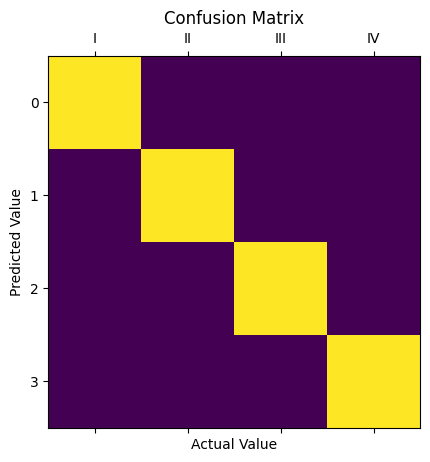

In [57]:
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks([0,1,2,3], ['I','II','III','IV'])

Let's go over one more example for implementation of a classification tree. 

In this section of the tutorial, we will build a classification tree using `titanic_df`. Note that because it has only categorical data, the values must be converted to numeric first. We will take care of that in the first code cell below. We will then build and analyze the classification tree in the subsequent code cells. 

In [61]:
# get desired columns
num_cols = pd.DataFrame(titanic_df[['Class', 'Sex', 'Age']])

# rename the columns to keep them distinct from original DataFrame
num_cols.rename(columns={'Class':'Class2', 'Sex':'Sex2', 'Age':'Age2'}, inplace=True)

# obtain the values to be converted
num_cols['Class2'].unique()
num_cols['Sex2'].unique()
num_cols['Age2'].unique()

# in week 9 tutorial we used the following method to convert values to numerical:  
# num_cols.Class2 = (num_cols.Class2.replace(['1st', '2nd', '3rd', 'Crew'], [0, 1, 2, 3]) 
#                   .infer_objects(copy=False))

# however this produces a warning related to converting data types (deprecation of downcasting behavior)
# we will use a different method based on discussion in https://github.com/pandas-dev/pandas/issues/57734

# convert Class2 to numeric
replace_dict = {'1st': '0', '2nd': '1', '3rd': '2', 'Crew': '3'}  # keys are str and so must be values
num_cols.Class2 = num_cols.Class2.replace(replace_dict).astype(int)  # cast values to int

# convert Sex2 to numeric
replace_dict = {'Female': '0', 'Male': '1'}
num_cols.Sex2 = num_cols.Sex2.replace(replace_dict).astype(int)

# convert Age2 to numeric
replace_dict = {'Child': '0', 'Adult': '1'}
num_cols.Age2 = num_cols.Age2.replace(replace_dict).astype(int)

# create new df with numeric columns
titanic_df_2 = pd.concat([titanic_df, num_cols], axis=1)
titanic_df_2.columns

Index(['Class', 'Sex', 'Age', 'Survived', 'Class2', 'Sex2', 'Age2'], dtype='object')

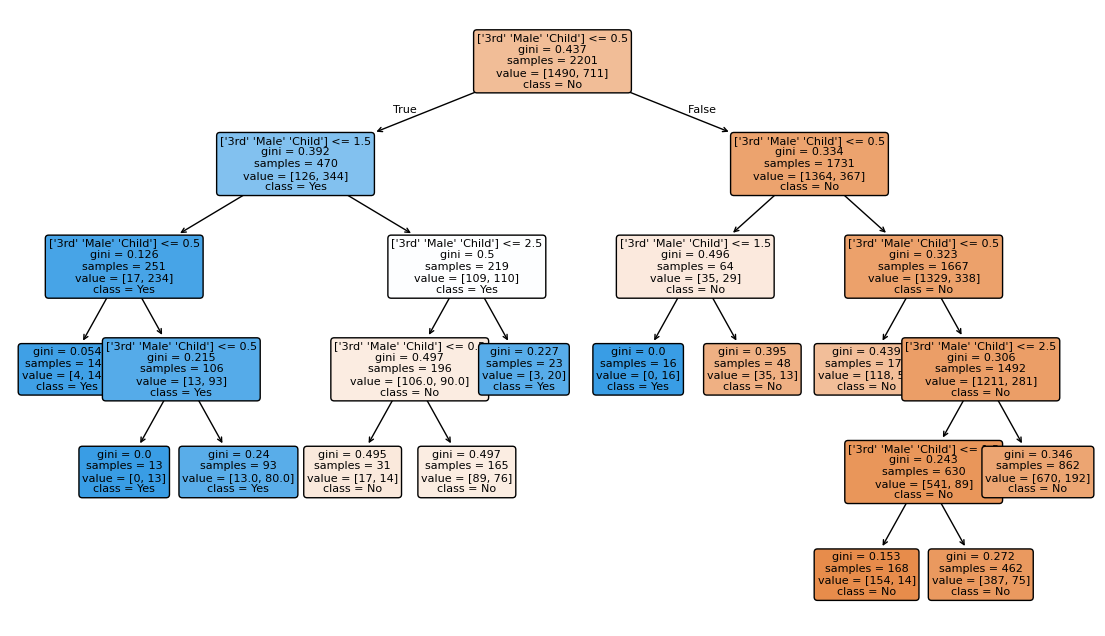

In [59]:
# create labels
col_names = list(titanic_df_2[['Class','Sex','Age']].values)
classnames = list(titanic_df_2['Survived'].unique())

# fit model
tree_model_3 = tree.DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=5).fit(titanic_df_2[['Class2','Sex2','Age2']], titanic_df_2['Survived'])

# visualize tree
plt.figure(figsize=(14,8))  # set plot size (denoted in inches)
tree.plot_tree(tree_model_3,
                feature_names=col_names,
                class_names=classnames,
                filled=True, rounded=True,
                fontsize=8)
plt.show()

              precision    recall  f1-score   support

          No       0.77      0.99      0.86      1490
         Yes       0.93      0.38      0.54       711

    accuracy                           0.79      2201
   macro avg       0.85      0.68      0.70      2201
weighted avg       0.82      0.79      0.76      2201

[[1470   20]
 [ 441  270]]


([<matplotlib.axis.XTick at 0x1763bbec200>,
 [Text(0, 1, 'Yes'), Text(1, 1, 'No')])

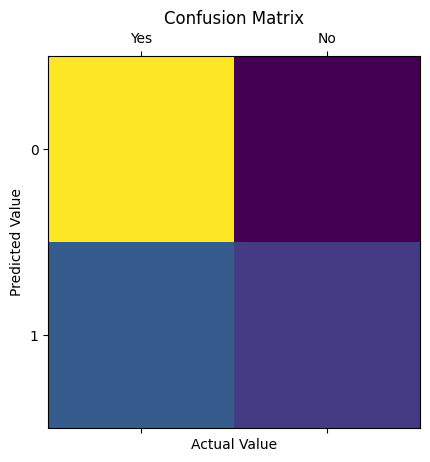

In [60]:
# get predicted values
predicted = tree_model_3.predict(titanic_df_2.iloc[:,4:7])

# get performance metrics for model evaluation
print(metcs.classification_report(titanic_df_2['Survived'], predicted))

# create and display confusion matrix
cm = metcs.confusion_matrix(titanic_df_2['Survived'], predicted)
print(cm)

# visualize confusion matrix
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks([0,1], ['Yes','No'])

This model's performance is not as great as the prior model we built with `taxon_complete_df`. Check out [this Towards Data Science article to learn more about performance metrics used to evaluate models](https://towardsdatascience.com/performance-metrics-confusion-matrix-precision-recall-and-f1-score-a8fe076a2262/). 

That wraps up our discussion of classification! 

---
## Further Reading

We have covered *a lot* of information in this tutorial. Please review it as needed. As with last week's content, we are limited in our ability to dive into statistical theory. Here is a set of free, open-source resources that you may find helpful in developing your statistics and Python expertise for analytics:

* [Improving Your Statistical Inferences by Daniël Lakens](https://lakens.github.io/statistical_inferences/)
* [Python Data Science Handbook by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/)
* [Think Stats: Probability and Statistics for Programmers by Allen B. Downey](https://greenteapress.com/thinkstats/thinkstats.pdf)

---

Originally, I planned to include a section on Artificial Neural Networks (ANN) in this tutorial. Given the complexity of these topics and approaches, I have decided to include the description and demos of ANN in an separate, *optional* tutorial that will be shared with the class during Week 10. Familiarizing yourself with the content in that tutorial is not required for this week's course assignments. However, it will be provided for those who are interested in learning about ANN and its implementation in Python. 